# Multivariate Pipeline Tutorial

This notebook demonstrates how to use the multivariate detector pipeline with different formatting methods for multidimensional time series data.


In [1]:
import numpy as np
import pandas as pd
from sigllm.primitives.formatting import (
    JSONFormat,
    UnivariateControl,
    PersistenceControl,
    ValueConcatenation,
    ValueInterleave,
    DigitInterleave,
    utils
)


## Create Sample Multivariate Data

First, let's create some sample multivariate time series data with 3 dimensions.


In [2]:
# Create sample data with 3 dimensions
N = 25
raw_data = utils.create_test_data()
print(raw_data.head())

raw_data = raw_data.to_numpy()[:, 1:]
windowed_data = np.array([raw_data[i:i+15,:] for i in range(0, len(raw_data)-15, 1)])
data = (1000 * windowed_data).astype(int)

print("Sample data shape:", data.shape)


   timestamp    x1  x2    x3
0        0.0  0.10   0  0.65
1     3600.0  0.11   1  0.64
2     7200.0  0.12   0  0.63
3    10800.0  0.13   1  0.62
4    14400.0  0.14   0  0.61
Sample data shape: (10, 15, 3)


## Available Formatting Methods

The multivariate pipeline supports several formatting methods to convert multi-dimensional data into string representations for LLM processing:

1. **JSONFormat**: Formats as d0:val,d1:val,... per timestamp
2. **ValueConcatenation**: Flattens all dimensions per timestamp
3. **ValueInterleave**: Interleaves values with zero-padding
4. **DigitInterleave**: Interleaves individual digits
5. **UnivariateControl**: Uses only first dimension (baseline)
6. **PersistenceControl**: Returns last value (naive baseline)


For example, given timesteps $t_0$ = [50, 30, 100] and $t_1$ = [55, 28, 104]:
* Value Concatenation - Simply flatten the values across time: 50,30,100,55,28,104
* Value Interleave - Pad values to equal digit length and concatenate timestep by timestep: 050030100,055028104
* Digit Interleave - Interleave digits positionally across dimensions: 001530000,001520584
* JSON Format - Encode as dimension-labeled key:value pairs: d0:50,d1:30,d2:100,d0:55,d1:28,d2:104
* Univariate Control - Keep only one dimension (baseline for comparison): 50,55
* Persistence Control - Bypass the formatting and return last known value: N/A


In [3]:
# Compare string representations from different methods
methods = {
    'JSONFormat': JSONFormat(),
    'ValueConcatenation': ValueConcatenation(),
    'ValueInterleave': ValueInterleave(),
    'DigitInterleave': DigitInterleave(),
    'UnivariateControl': UnivariateControl(),
    'PersistenceControl': PersistenceControl(),
}


Validation suite passed
Validation suite passed
Validation suite passed
Validation suite passed
Validation suite passed


In [4]:
print("Comparison of formatting methods on the same data:\n")



for name, method in methods.items():
    try:
        print(f"{name}:")
        output = method.format_as_string(data)
        print(f"\t{output[0][:80]}...\n")
    except Exception as e:
        print(f"{name}: Error - {e}\n")

Comparison of formatting methods on the same data:

JSONFormat:
	d0:100,d1:0,d2:650,d0:110,d1:1000,d2:640,d0:120,d1:0,d2:630,d0:130,d1:1000,d2:62...

ValueConcatenation:
	100,0,650,110,1000,640,120,0,630,130,1000,620,140,0,610,150,1000,600,160,0,590,1...

ValueInterleave:
	010000000650,011010000640,012000000630,013010000620,014000000610,015010000600,01...

DigitInterleave:
	000106005000,010106104000,000106203000,010106302000,000106401000,010106500000,00...

UnivariateControl:
	100,110,120,130,140,150,160,170,180,190,200,210,220,230,240...

PersistenceControl:
	100,110,120,130,140,150,160,170,180,190,200,210,220,230,240...



# Deep dive into JSONFormat

In this section, we show an end-to-end use of the multivariate detector pipeline in two different ways. We first show how to use a utility function that runs the full pipeline. 

In [5]:
from sigllm.primitives.formatting.utils import test_multivariate_formatting_validity, run_pipeline

method = JSONFormat()
test_multivariate_formatting_validity(method)
errors, y_hat, y = run_pipeline(method, multivariate_allowed_symbols=["d", ":", ","], verbose=False)
print(f"Mean Residual: {np.mean(errors)}")

Validation suite passed
Validation suite passed


/home/baranov/miniconda/envs/orion310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-09 19:49:26.974769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 19:49:27.006293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-09 19:49:27.006329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-09 19:49:27.006360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugi

Mean Residual: 0.0


## Step-by-Step Pipeline Execution

MLPipelines are composed of a sequence of primitives. These primitives apply transformation and calculation operations to the data and update the variables within the pipeline. To view the primitives used by the pipeline, we access its `primitives` attribute.

The multivariate mistral detector with JSON format contains 12 primitives. We will observe how the context (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [6]:
from mlblocks import MLPipeline

pipeline = MLPipeline('multivariate_mistral_detector_jsonformat')

hyperparameters = {
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        "interval": 3600
    },
    "sigllm.primitives.forecasting.custom.rolling_window_sequences#1": {
        "window_size": 50,
        "target_size": 1
    },
    "sigllm.primitives.forecasting.huggingface.HF#1": {
        "samples": 1,
    },
    "sigllm.primitives.formatting.json_format.format_as_integer#1": {
        "trunc": 1
    }
}
pipeline.set_hyperparameters(hyperparameters)

pipeline.primitives

Validation suite passed


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Validation suite passed


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]
Some parameters are on the meta device because they were offloaded to the cpu.


Validation suite passed


['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'sigllm.primitives.transformation.Float2Scalar',
 'sigllm.primitives.forecasting.custom.rolling_window_sequences',
 'sigllm.primitives.formatting.json_format.format_as_string',
 'sigllm.primitives.forecasting.huggingface.HF',
 'sigllm.primitives.formatting.json_format.format_as_integer',
 'sigllm.primitives.transformation.Scalar2Float',
 'sigllm.primitives.postprocessing.aggregate_rolling_window',
 'numpy.reshape',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_anomalies.find_anomalies']

### Load Sample Data

For this tutorial, we'll use a sample signal from the Orion dataset.

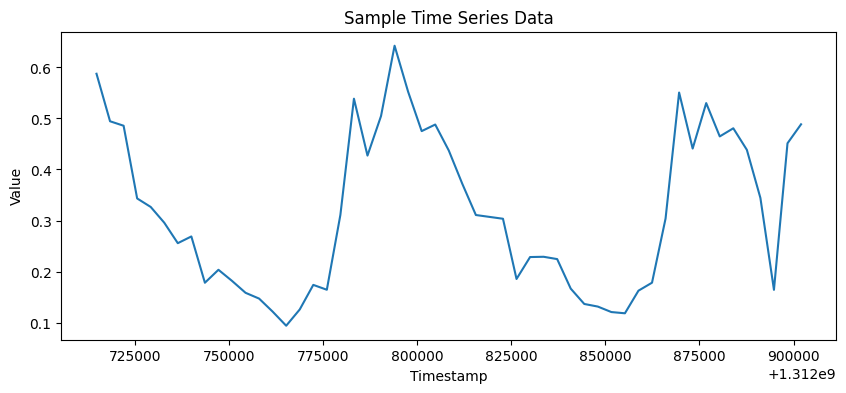

Data shape: (52, 2)


In [7]:
from orion.data import load_signal
import matplotlib.pyplot as plt

signal_data = load_signal('exchange-2_cpm_results')

start = 900
end = start + 52
signal_data = signal_data.iloc[start:end]

plt.figure(figsize=(10, 4))
plt.plot(signal_data['timestamp'], signal_data['value'])
plt.title('Sample Time Series Data')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

print(f"Data shape: {signal_data.shape}")

### Step 0: Time Segments Aggregate

This primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    * `X` sequence of aggregated values, one column for each aggregation method.
    * `index` sequence of index values (first index of each aggregated segment).

In [8]:
step = 0
context = pipeline.fit(signal_data, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")
print(f"X shape: {context['X'].shape}")

for i, x in list(zip(context['index'], context['X']))[:5]:
    print(f"entry at {i} has value {x}")

Context keys: ['X', 'index']
X shape: (53, 1)
entry at 1312714801 has value [0.58756715]
entry at 1312718401 has value [0.49446836]
entry at 1312722001 has value [0.48571948]
entry at 1312725601 has value [0.34325765]
entry at 1312729201 has value [0.32660771]


### Step 1: SimpleImputer

This primitive is an imputation transformer for filling missing values.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `y` which is a transformed version of 'X'.

In [9]:
step = 1
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

Context keys: ['index', 'X', 'y']


### Step 2: Float2Scalar

This primitive converts float values into scalar up to certain decimal points.

* **input**: `y` which is an n-dimensional sequence of values in float type.
* **output**: `X` which is a transformed version of 'y' in scalar.

In [10]:
step = 2
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

for i, x in list(zip(context['index'], context['X']))[:5]:
    print(f"entry at {i} has value {x}")

print(f"\nMinimum value stored: {context['minimum']}")

Context keys: ['index', 'X', 'y', 'minimum', 'decimal']
entry at 1312714801 has value [49]
entry at 1312718401 has value [40]
entry at 1312722001 has value [39]
entry at 1312725601 has value [25]
entry at 1312729201 has value [23]

Minimum value stored: 0.0939121008678


### Step 3: Rolling Window Sequences

This primitive generates many sub-sequences of the original sequence using a rolling window approach.

* **input**:
    * `X` n-dimensional sequence to iterate over.
    * `y` 1-dimensional target sequence.
    * `index` array containing the index values of X.
* **output**:
    * `X` input sequences.
    * `y` target sequences.
    * `index` first index value of each input sequence.
    * `target_index` first index value of each target sequence.

In [11]:
step = 3
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

# After slicing X into multiple sub-sequences we obtain a 3D matrix
print(f"\nX shape = {context['X'].shape}")
print(f"y shape = {context['y'].shape}")
print(f"X index shape = {context['index'].shape}")
print(f"y index shape = {context['target_index'].shape}")

Context keys: ['index', 'minimum', 'decimal', 'X', 'y', 'target_index']

X shape = (3, 50, 1)
y shape = (3, 1)
X index shape = (3,)
y index shape = (3,)


### Step 4: JSON Format as String

This primitive converts each sequence of scalar values into a JSON-like string format (`d0:val,d1:val,...`). This is the key step that formats multivariate data for the LLM.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a string representation version of X in JSON format.

In [12]:
step = 4
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

# Inspect the JSON-formatted string
if len(context['X']) > 0:
    sample_string = context['X'][0]
    print(f"\nSample JSON-formatted string (first 200 chars):")
    print(sample_string[:200] + "...")
else:
    print(f"\nWarning: X is empty! Length: {len(context['X'])}")
    print("This may happen if the data segment is too small for the window size.")

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'X', 'y']

Sample JSON-formatted string (first 200 chars):
d0:49,d0:40,d0:39,d0:25,d0:23,d0:20,d0:16,d0:17,d0:8,d0:11,d0:9,d0:6,d0:5,d0:3,d0:0,d0:3,d0:8,d0:7,d0:22,d0:44,d0:33,d0:41,d0:55,d0:46,d0:38,d0:39,d0:34,d0:28,d0:22,d0:22,d0:21,d0:9,d0:13,d0:14,d0:13,...


### Step 5: HuggingFace Model (HF)

This primitive prompts a HuggingFace model (Mistral) to forecast the next steps. The model is configured with `multivariate_allowed_symbols` to allow the JSON format tokens (`d`, `:`, `,`).

* **input**: `X` input sequence (JSON-formatted strings).
* **output**: `y_hat` predicted sequence.

<div class="alert alert-block alert-warning">
<b>Warning:</b> This step is time consuming depending on the number of windows.
</div>

In [13]:
step = 5
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

y_hat = context.get('y_hat', [])
if len(y_hat) > 0:
    print(f"\ny_hat shape: {np.array(y_hat).shape}")
    print(f"\nSample predictions (first 3 windows):")
    for i, pred in enumerate(y_hat[:3]):
        print(f"  Window {i}: {pred}")
else:
    print("\nWarning: y_hat is empty!")

100%|██████████| 3/3 [01:59<00:00, 39.78s/it]

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'X', 'y', 'y_hat']

y_hat shape: (3, 1)

Sample predictions (first 3 windows):
  Window 0: [',d0:35,d0:46,d0:47,d0:45,d0:2']
  Window 1: [',d0:9,d0:7,d0:8,d0:45,d0:43,d']
  Window 2: [',d0:47,d0:55,d0:54,d0:14,d0:1']


### Step 6: JSON Format as Integer

This primitive parses the model output and extracts values from the JSON-like format back to integers.

* **input**: `y_hat` which is a sequence of JSON-formatted string values.
* **output**: `y_hat` which is an integer representation version of y_hat.

In [14]:
step = 6
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

y_hat = np.array(context['y_hat'])
print(f"\ny_hat shape: {y_hat.shape}")
print(f"y_hat dtype: {y_hat.dtype}")
print(f"\nSample parsed values (first 5):")
print(y_hat[:5])

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y']

y_hat shape: (3, 1, 1)
y_hat dtype: object

Sample parsed values (first 5):
[[[35]]

 [[9]]

 [[47]]]


### Step 7: Scalar2Float

This primitive converts integer values back into float and adds the minimum value that was stored earlier.

* **input**:
    * `y_hat` sequence of integer values.
    * `minimum` value to add to shift by.
* **output**: `y_hat` which is a transformed version of `y_hat` in float.

In [15]:
step = 7
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

print(f"\ny_hat shape: {context['y_hat'].shape}")
print(f"\nSample float values (first 5):")
print(context['y_hat'][:5])

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y']

y_hat shape: (3, 1, 1)

Sample float values (first 5):
[[[0.44391210086780003]]

 [[0.1839121008678]]

 [[0.5639121008678001]]]


### Step 8: Aggregate Rolling Window

This primitive aggregates multiple horizon predictions into a single representation.

* **input**:
    * `y_hat` n-dimensional sequence of forecasted values.
    * `agg` aggregation method, "median" by default.
* **output**: `y_hat` one-dimensional output sequence depicting the aggregated value of forecasts.

In [16]:
step = 8
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

print(f"\ny_hat shape: {context['y_hat'].shape}")
print(f"y_hat: {context['y_hat']}")

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y']

y_hat shape: (3,)
y_hat: [0.4439121 0.1839121 0.5639121]


### Step 9: Reshape

Reshape `y_hat` sequences to the expected format.

* **input**: `y_hat` forecasted and aggregated sequences.
* **output**: `y_hat` reshaped sequences.

In [17]:
step = 9
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

print(f"\ny_hat shape: {context['y_hat'].shape}")

print(f"y_hat: {context['y_hat']}")
block = pipeline.blocks['sigllm.primitives.formatting.json_format.format_as_integer#1']
print(f"format_as_integer hyperparameters: {block.get_hyperparameters()}")

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y']

y_hat shape: (3, 1)
y_hat: [[0.4439121]
 [0.1839121]
 [0.5639121]]
format_as_integer hyperparameters: {'trunc': 1, 'steps_ahead': None}


### Step 10: Regression Errors

This primitive computes the point-wise difference between `y` and `y_hat`.

* **input**:
    * `y` target sequences.
    * `y_hat` forecasted sequences.
* **output**: `errors` computed errors.

In [18]:
step = 10
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

print(f"\nerrors shape: {context['errors'].shape}")
print(f"y_hat shape: {context['y_hat'].shape}")

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'X', 'y', 'errors']

errors shape: (3,)
y_hat shape: (3, 1)


### Step 11: Find Anomalies

This primitive extracts anomalies from sequences of errors following the approach explained in the [related paper](https://arxiv.org/pdf/1802.04431.pdf).

* **input**:
    * `errors` array of errors.
    * `target_index` array of indices of errors.
* **output**: `anomalies` array containing start-index, end-index, score for each anomalous sequence that was found.

In [19]:
step = 11
context = pipeline.fit(**context, start_=step, output_=step)
print(f"Context keys: {list(context.keys())}")

# Display detected anomalies
anomalies = context.get('anomalies', [])
if len(anomalies) > 0:
    anomalies_df = pd.DataFrame(anomalies, columns=['start', 'end', 'score'])
    print("\nDetected anomalies:")
    display(anomalies_df)
else:
    print("\nNo anomalies detected.")

Context keys: ['index', 'minimum', 'decimal', 'target_index', 'y_hat', 'errors', 'X', 'y', 'anomalies']

No anomalies detected.


### Visualization

Plot the original signal, forecasts, errors, and detected anomalies.

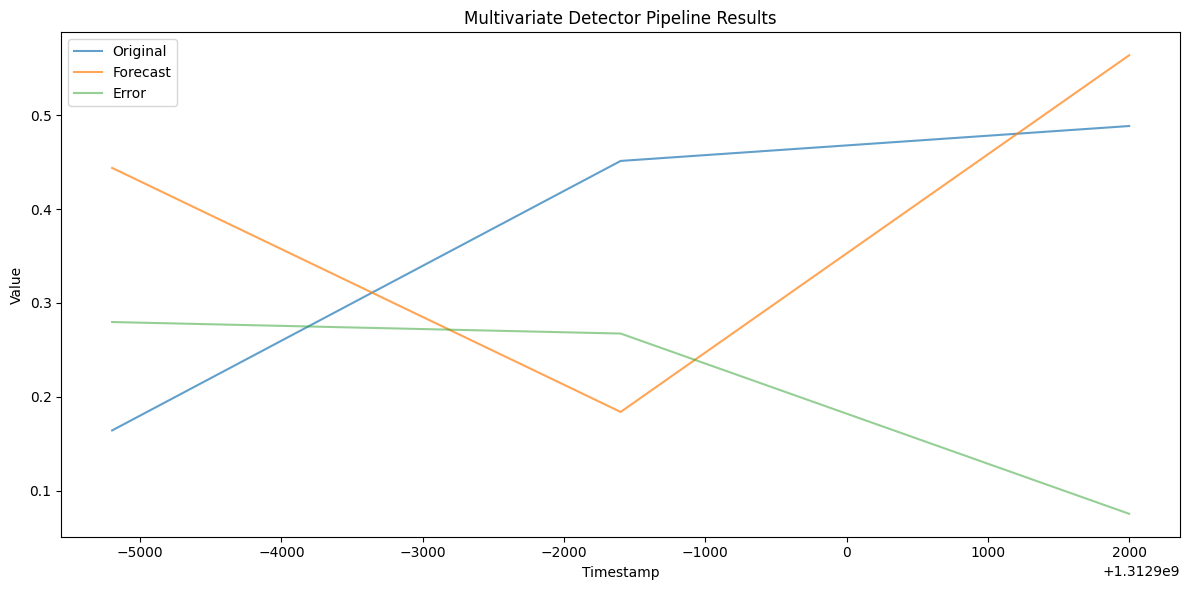

In [20]:
index = context.get('target_index', [])
y = context.get('y', [])
yhat = context.get('y_hat', [])
errors = context.get('errors', [])
anomalies = context.get('anomalies', [])

if len(index) > 0 and len(y) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(index, y, label='Original', alpha=0.7)
    if len(yhat) > 0:
        plt.plot(index, yhat, label='Forecast', alpha=0.7)
    if len(errors) > 0:
        plt.plot(index, errors, label='Error', alpha=0.5)

    # Highlight detected anomalies
    for anomaly in anomalies:
        plt.axvspan(anomaly[0], anomaly[1], color='r', alpha=0.2, label='Detected Anomaly')

    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Multivariate Detector Pipeline Results')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to visualize. Please check pipeline execution.")